## Change of displacement before and after ER stress

In [1]:
import os
from os.path import join, basename
from tkinter import filedialog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(color_codes=True, style="white")

# Parameters
mean_step_size_threshold_nm = 0
conversion_factor = 117  # Only if needed for other calculations

# Use file dialog to select CSV files for each condition
csv_files_1 = filedialog.askopenfilenames(
    title="Select CSV Files for ER stress cells",
    filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
)
csv_files_2 = filedialog.askopenfilenames(
    title="Select CSV Files for normal cells",
    filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
)

# Function to load CSV files and add a 'Condition' column
def load_and_label_files(file_paths, label):
    combined_df_list = []
    for file in file_paths:
        df = pd.read_csv(file)
        df['Condition'] = label
        df['title'] = basename(file)
        # Ensure displacement_nm column exists and drop NaNs
        if 'displacement_nm' in df.columns:
            df = df.dropna(subset=['displacement_nm'])
        combined_df_list.append(df)
    combined_df = pd.concat(combined_df_list, ignore_index=True)
    return combined_df

# Load and label CSV files for each condition
df_condition1 = load_and_label_files(csv_files_1, '+ Stress')
df_condition2 = load_and_label_files(csv_files_2, '- Stress')

# Combine the data from all conditions
df_combined = pd.concat([df_condition1, df_condition2], ignore_index=True)

# Filter by mean step size if the column exists
if 'mean_stepsize_nm' in df_combined.columns:
    final_filtered_df = df_combined[df_combined['mean_stepsize_nm'] > mean_step_size_threshold_nm]
else:
    print("Warning: 'mean_stepsize_nm' column not found. Skipping mean step size filtration.")
    final_filtered_df = df_combined

# Function to calculate unique trackID count
def calculate_unique_trackID_count(filtered_df, condition):
    condition_df = filtered_df[filtered_df['Condition'] == condition]
    unique_titles = condition_df['title'].unique()
    unique_trackID_count = 0
    for title in unique_titles:
        unique_trackID_count += condition_df[condition_df['title'] == title]['trackID'].nunique()
    return unique_trackID_count

# Calculate sample sizes
n_with_stress = calculate_unique_trackID_count(final_filtered_df, '+ Stress')
n_without_stress = calculate_unique_trackID_count(final_filtered_df, '- Stress')



c:\Users\bisal\.conda\envs\spt-simplified-20240126\lib\site-packages\seaborn\_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bisal\.conda\envs\spt-simplified-20240126\lib\site-packages\seaborn\_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bisal\.conda\envs\spt-simplified-20240126\lib\site-packages\seaborn\_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

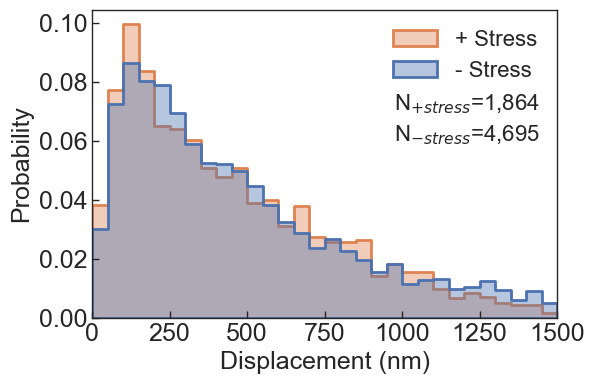

In [4]:
# Plot the probability distribution for each condition without KDE
color_dict = {"+ Stress": "#DD8452", "- Stress": "#4C72B0"}
plt.figure(figsize=(6, 4))
bins = 30

ax = sns.histplot(
    data=final_filtered_df,
    x='displacement_nm',
    hue="Condition",
    bins=bins,
    stat="probability",
    common_norm=False,
    binrange=(0, 1500),  # Adjust this range as needed for your displacement data
    lw=2,
    element="step",
    fill=True,
    alpha=0.4,
    palette=color_dict,
    hue_order=["- Stress", "+ Stress"]  # Note: This is REVERSED from the legend order
)

# Reverse the legend handles and set labels
handles = ax.legend_.legendHandles [::-1]
ax.legend(handles, ['+ Stress', '- Stress'], fontsize=16)  # Labels in desired legend order

legend = ax.get_legend()
legend.set_title(None)
legend_frame = legend.get_frame()
legend_frame.set_visible(False)

# Add sample size annotations
plt.text(
    0.65, 0.73,  # Adjust position as needed
    r"N$_{+stress}$=" + f"{n_with_stress:,}",
    fontdict={"fontsize": 16},
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.text(
    0.65, 0.63,  # Adjust position as needed
    r"N$_{-stress}$=" + f"{n_without_stress:,}",
    fontdict={"fontsize": 16},
    transform=ax.transAxes,
    verticalalignment='top'
)

# Set axis limits and labels
plt.xlim(0, 1500)  # Adjust as needed
plt.ylim(0, None)
plt.xlabel('Displacement (nm)', fontsize=18)
plt.ylabel("Probability", fontsize=18)

# Customize spines and ticks
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)

# Save the figure
plt.savefig("displacement_histo.png", format="png", bbox_inches="tight", dpi=600)
plt.show()

In [6]:
# Add this after calculating the sample sizes:

print("\n=== FILE-BY-FILE DISPLACEMENT ANALYSIS ===")

# Function to calculate mean displacement per file
def analyze_file_displacements(filtered_df, condition_name):
    condition_df = filtered_df[filtered_df['Condition'] == condition_name]
    file_stats = []
    
    for title in condition_df['title'].unique():
        file_df = condition_df[condition_df['title'] == title]
        mean_disp = file_df['displacement_nm'].mean()
        n_tracks = file_df['trackID'].nunique()
        n_points = len(file_df)
        file_stats.append({
            'File': title,
            'Mean Displacement (nm)': mean_disp,
            'Number of Tracks': n_tracks,
            'Number of Points': n_points
        })
    
    return pd.DataFrame(file_stats)

# Analyze each condition
print("\n+ Stress (ER Stress) files analysis:")
plus_stress_stats = analyze_file_displacements(final_filtered_df, '+ Stress')
print(plus_stress_stats.to_string(index=False))

print("\n- Stress (Normal) files analysis:")
minus_stress_stats = analyze_file_displacements(final_filtered_df, '- Stress')
print(minus_stress_stats.to_string(index=False))

# Calculate overall means for comparison
print(f"\n=== OVERALL SUMMARY ===")
print(f"+ Stress (ER Stress) overall mean: {plus_stress_stats['Mean Displacement (nm)'].mean():.2f} nm")
print(f"- Stress (Normal) overall mean: {minus_stress_stats['Mean Displacement (nm)'].mean():.2f} nm")

# Also show median for a more robust measure
print(f"\n=== MEDIAN DISPLACEMENT (per file) ===")
print(f"+ Stress (ER Stress) median of file means: {plus_stress_stats['Mean Displacement (nm)'].median():.2f} nm")
print(f"- Stress (Normal) median of file means: {minus_stress_stats['Mean Displacement (nm)'].median():.2f} nm")


=== FILE-BY-FILE DISPLACEMENT ANALYSIS ===

+ Stress (ER Stress) files analysis:
                                                                                      File  Mean Displacement (nm)  Number of Tracks  Number of Points
SPT_results_AIO-20251026_UGD_ER_thapsigargin_0-5uM_24h_2x_rep1_FOV-1_spots_reformatted.csv              539.522207               450               450
SPT_results_AIO-20251117_UGD_ER_thapsigargin_0_5uM_24h_2x_rep1_FOV-2_spots_reformatted.csv              414.578173               232               232
SPT_results_AIO-20251117_UGD_ER_thapsigargin_0_5uM_24h_2x_rep1_FOV-3_spots_reformatted.csv              528.519708               308               308
SPT_results_AIO-20251117_UGD_ER_thapsigargin_0_5uM_24h_2x_rep1_FOV-4_spots_reformatted.csv              536.193820               369               369
  SPT_results_AIO-20251117_UGD_ER_thapsigargin_0_5uM_24h_2x_rep1_FOV_spots_reformatted.csv              354.098237               505               505

- Stress (N